In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housing_raw = pd.read_csv("../Data/housing_data.csv",parse_dates=["period_begin", "period_end"])

ca_housing = (
    housing_raw
    .loc[(housing_raw["region_name"].str.contains("CA"))]
    .assign(region_name = housing_raw["region_name"].str[0:-11])
    .query("region_name in ['San Francisco', 'Los Angeles', 'San Diego', 'Tulare']")
)

ca_housing_pivot = (ca_housing
                    .pivot_table(
                        index="period_begin",
                        columns="region_name",
                        values="median_active_list_price"
                    )
)

ca_housing_pivot.head(3)

region_name,Los Angeles,San Diego,San Francisco,Tulare
period_begin,,,,
2017-01-02,611561.0,618570.8,1229018.7,225395.8
2017-01-09,614061.0,621737.5,1233393.7,227729.1
2017-01-16,617311.0,625820.8,1239977.0,229060.4


## Subplots

Text(0.5, 1.0, 'San Francisco')

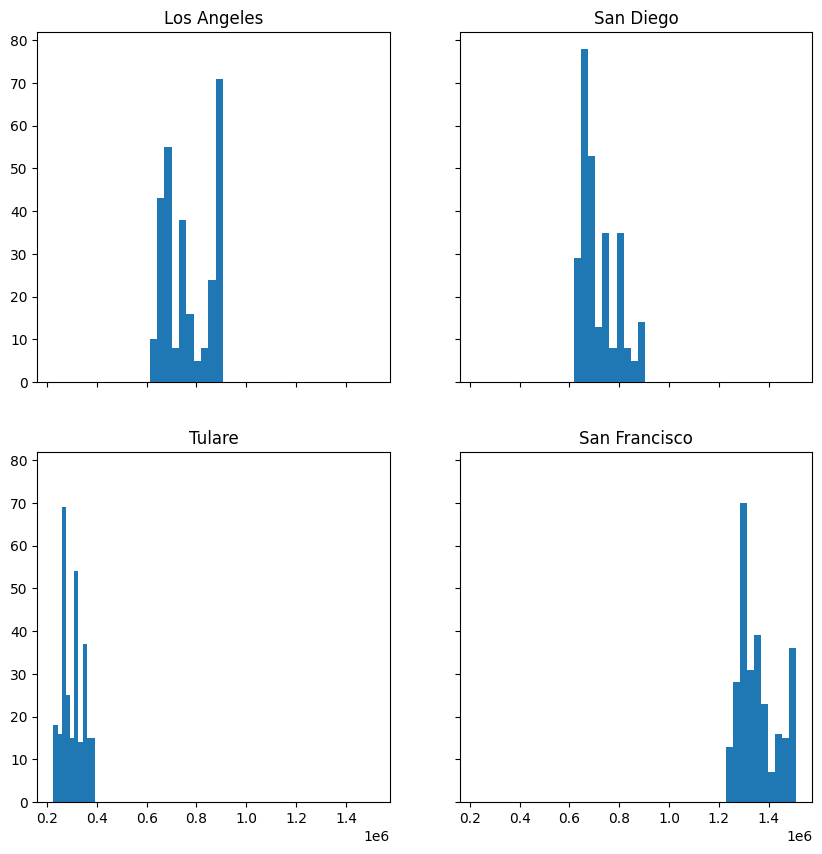

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey="all", sharex="all")

ax[0][0].hist(ca_housing_pivot["Los Angeles"])
ax[0][0].set_title("Los Angeles")

ax[0][1].hist(ca_housing_pivot["San Diego"])
ax[0][1].set_title("San Diego")

ax[1][0].hist(ca_housing_pivot["Tulare"])
ax[1][0].set_title("Tulare")

ax[1][1].hist(ca_housing_pivot["San Francisco"])
ax[1][1].set_title("San Francisco")

In [4]:
# data prep for new subplot grid

price_by_region = (
    ca_housing.groupby("region_name")
    .agg({"median_active_list_price": "mean"})
)

price_by_month = (
    ca_housing
    .groupby(ca_housing["period_begin"].dt.month)
    .agg({"median_active_list_price": "mean"})
)

price_by_r_m = (
    ca_housing.groupby(["region_name", ca_housing["period_begin"].dt.year, ca_housing["period_begin"].dt.month])
    .agg({"median_active_list_price": "mean"})
)

Text(0.5, 1.0, 'San Diego Vs. LA Prices')

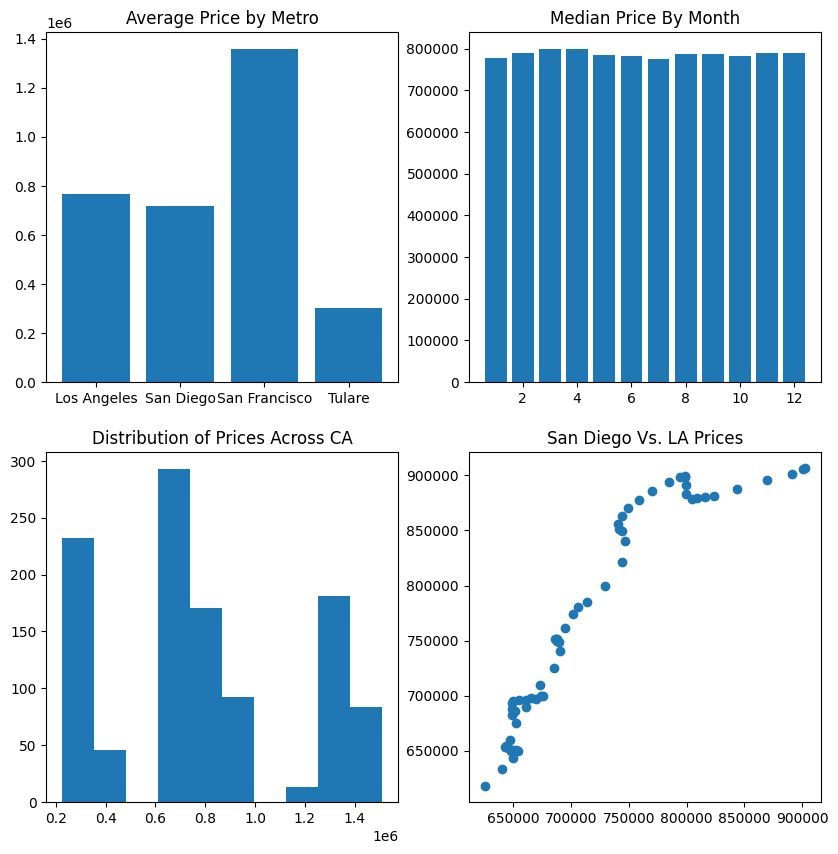

In [5]:
# Subplots can have mixed chart types

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].bar(
    price_by_region.index, 
    price_by_region["median_active_list_price"]
)
ax[0][0].set_title("Average Price by Metro")

ax[0][1].bar(
    price_by_month.index, 
    price_by_month["median_active_list_price"]
)
ax[0][1].set_title("Median Price By Month")

ax[1][0].hist(ca_housing["median_active_list_price"])
ax[1][0].set_title("Distribution of Prices Across CA")


ax[1][1].scatter(
    price_by_r_m.loc["San Diego", "median_active_list_price"],
    price_by_r_m.loc["Los Angeles", "median_active_list_price"]
)
ax[1][1].set_title("San Diego Vs. LA Prices")

# GridSpec

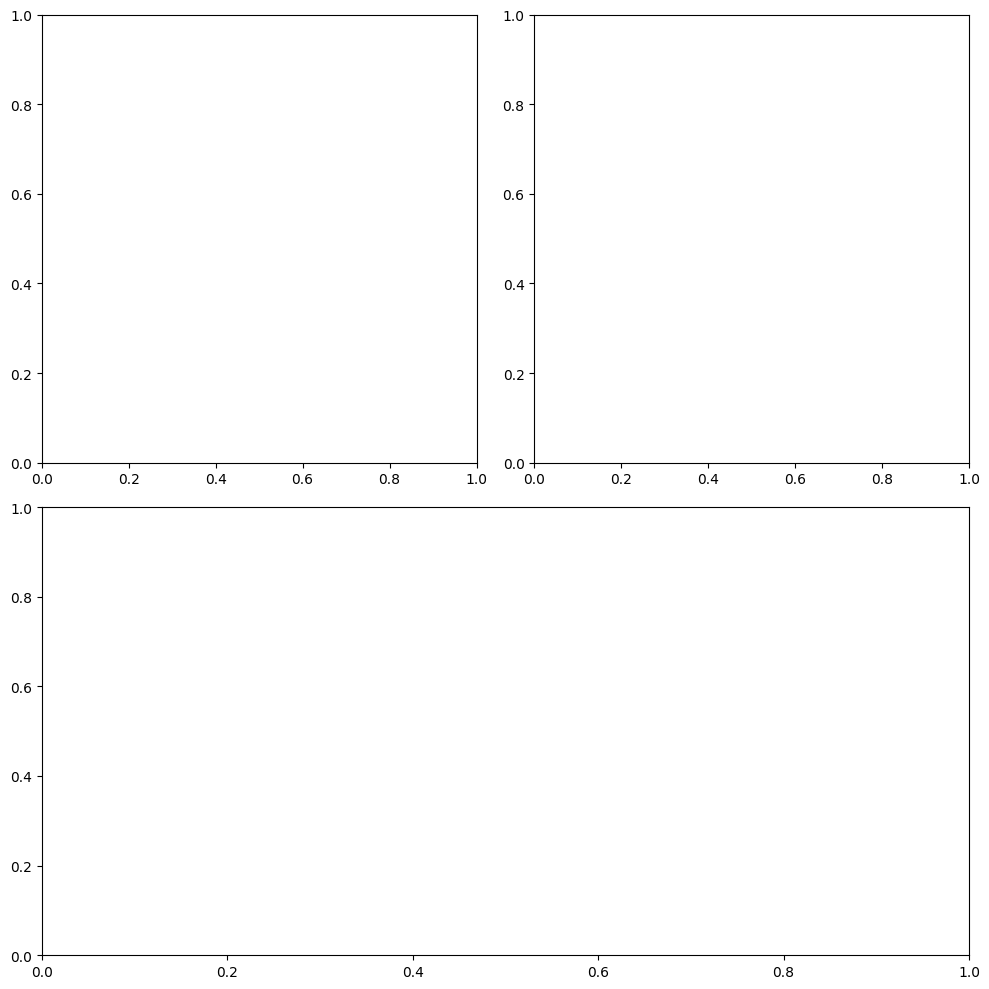

In [6]:
# empty grid layout

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(ncols=4, nrows=8)

ax1 = fig.add_subplot(gs[0:4, 0:2])
ax2 = fig.add_subplot(gs[0:4, 2:])
ax3 = fig.add_subplot(gs[4:, :])

fig.tight_layout()

In [7]:
# data prep to fill layout

LA_SF=(ca_housing
 .query("region_name in ['Los Angeles', 'San Francisco'] and period_begin.dt.year == 2020")
 .pivot_table(index="period_begin",
              columns="region_name",
              values=["total_homes_sold", "median_active_list_price"],
              aggfunc="mean")
             )

two_year = LA_SF.resample("M").mean()

two_year_LA = (two_year.reset_index()
               .assign(year=lambda x: x.iloc[:, 0].dt.year,
                       month=lambda x: x.iloc[:, 0].dt.month)
               .iloc[:, [0, 3, 5, 6]]
              )

two_year_LA.columns= ["Date", "Homes Sold", "Year", "Month"]

totals_jan = [LA_SF.iloc[0, 1], LA_SF.iloc[0, 0]]

totals_dec = [LA_SF.iloc[-1, 1], LA_SF.iloc[-1, 0]]

/var/folders/mv/y6dng09x31s7lvvx2x62hf1r0000gn/T/ipykernel_31581/4141553059.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  two_year = LA_SF.resample("M").mean()


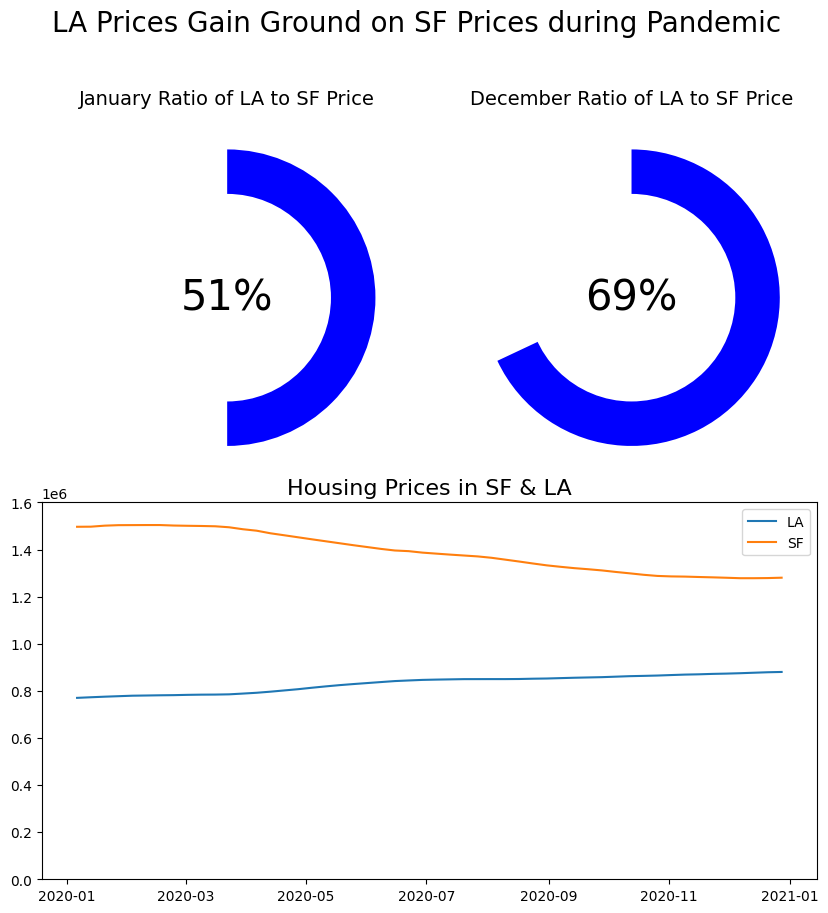

In [8]:

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(ncols=4, nrows=8)

fig.suptitle("LA Prices Gain Ground on SF Prices during Pandemic", fontsize=20)

ax1 = fig.add_subplot(gs[0:4, 0:2])


ax1.pie([.5, .5],
        startangle=90,
        labels = ["", ""],
        #autopct='%.0f%%',
        pctdistance=.85,
        colors=["White", "Blue"])

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.text(
    0, 0, 
    f"{round((totals_jan[1] / totals_jan[0])*100)}%", 
    ha='center', 
    va='center', 
     fontsize=30
)
ax1.set_title("January Ratio of LA to SF Price", fontsize=14)

ax2 = fig.add_subplot(gs[0:4, 2:])
ax2.pie(
    [.32, .68],
    startangle=90,
    labels = ["", ""],
    pctdistance=.85,
    colors=["White", "Blue"]
)

hole = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(hole)
plt.text(
    0, 0, 
    f"{round((totals_dec[1] / totals_dec[0]*100))}%", 
    ha='center', 
    va='center', 
    fontsize=30
)
  
ax2.set_title("December Ratio of LA to SF Price", fontsize=14)

ax3 = fig.add_subplot(gs[4:, :])
ax3.plot(LA_SF.iloc[:, 0:2])
ax3.set_title("Housing Prices in SF & LA", fontsize=16)
ax3.set_ylim(0, 1600000)

ax3.legend(["LA", "SF"])

# Colors

In [9]:
means = pd.DataFrame(ca_housing_pivot.mean())

means.columns = ["Mean Price"]

means.round().head()

,Mean Price
region_name,
Los Angeles,768225.0
San Diego,716818.0
San Francisco,1358263.0
Tulare,303796.0


<BarContainer object of 4 artists>

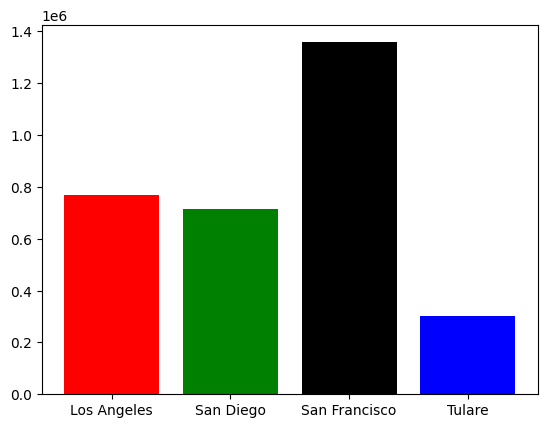

In [10]:
colors = ["red", "green", "black", "blue"]

fig, ax = plt.subplots()

ax.bar(means.index, means["Mean Price"], color=colors)

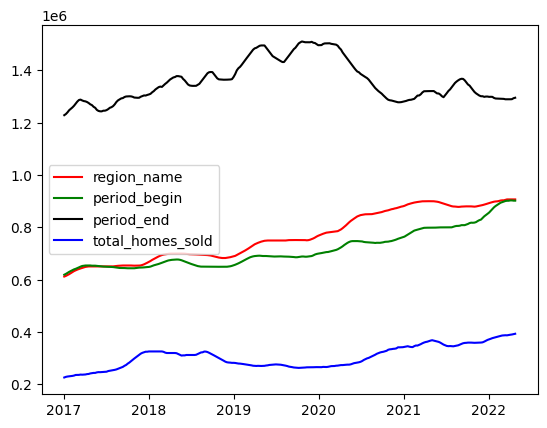

In [11]:
fig, ax = plt.subplots()

colors = ["red", "green", "black", "blue"]

for i, color in enumerate(colors):
    ax.plot(
        ca_housing_pivot.index, 
        ca_housing_pivot.iloc[:, i],
        c=color,
        label=ca_housing.columns[i]
    )
    
ax.legend()

In [12]:
# Hexcodes can also be used to specify colors

colors = ["#FF2D00", "#178C36", "#000000", "#1A17D0"]

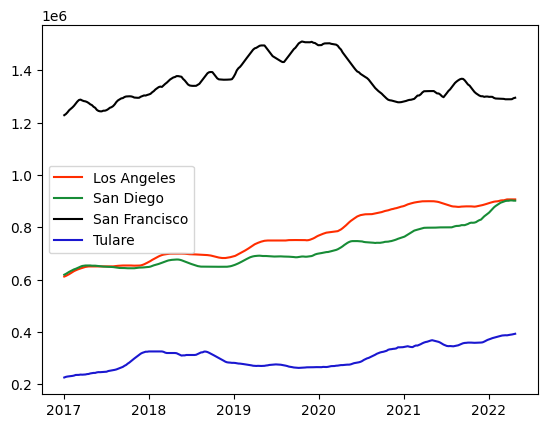

In [13]:
fig, ax = plt.subplots()

for i, color in enumerate(colors):
    ax.plot(
        ca_housing_pivot.index, 
        ca_housing_pivot.iloc[:, i], 
        c=color,
        label=ca_housing_pivot.columns[i]
    )
    
ax.legend()

# Colormaps

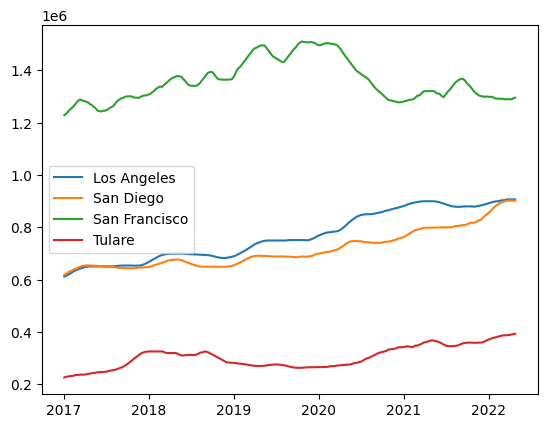

In [14]:
fig, ax = plt.subplots()

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)

for i in range(4):
    ax.plot(ca_housing_pivot.index, ca_housing_pivot.iloc[:, i] )

ax.legend(ca_housing_pivot.columns)

plt.show()

<BarContainer object of 4 artists>

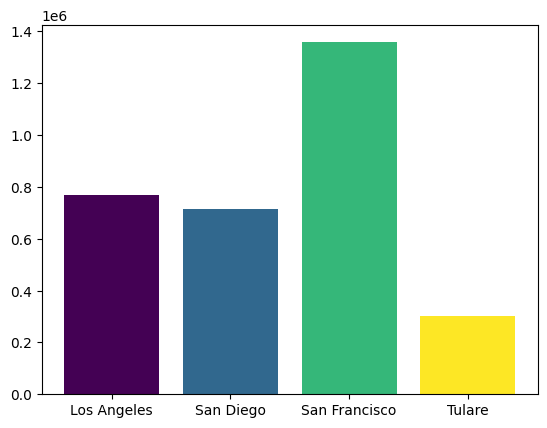

In [15]:
fig, ax = plt.subplots()

my_cmap = plt.get_cmap("viridis")
colors = np.linspace(0, 1, len(means.values))

ax.bar(means.index, means["Mean Price"], color=my_cmap(colors))


Text(0, 0.5, 'Price (M USD)')

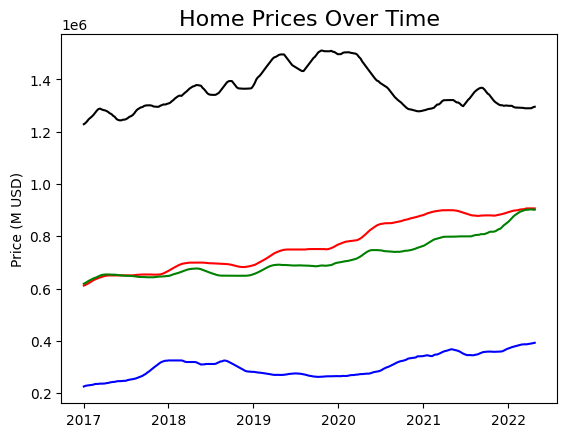

In [16]:
# Create your own custom color cycle

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["red", "green", "black", "blue"])

fig, ax = plt.subplots()

ax.plot(ca_housing_pivot)

ax.set_title("Home Prices Over Time", fontsize=16)
ax.set_ylabel("Price (M USD)")

# Style Sheets

<BarContainer object of 4 artists>

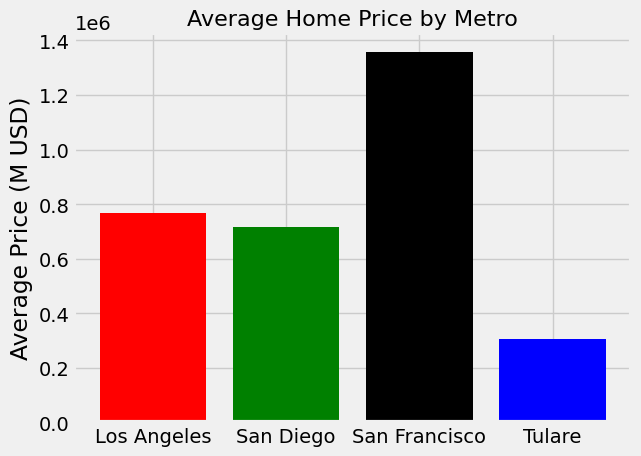

In [17]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots()

ax.set_title("Average Home Price by Metro", fontsize=16)
ax.set_ylabel("Average Price (M USD)")

colors = ["red", "green", "black", "blue"]

ax.bar(means.index, means["Mean Price"], color=colors)


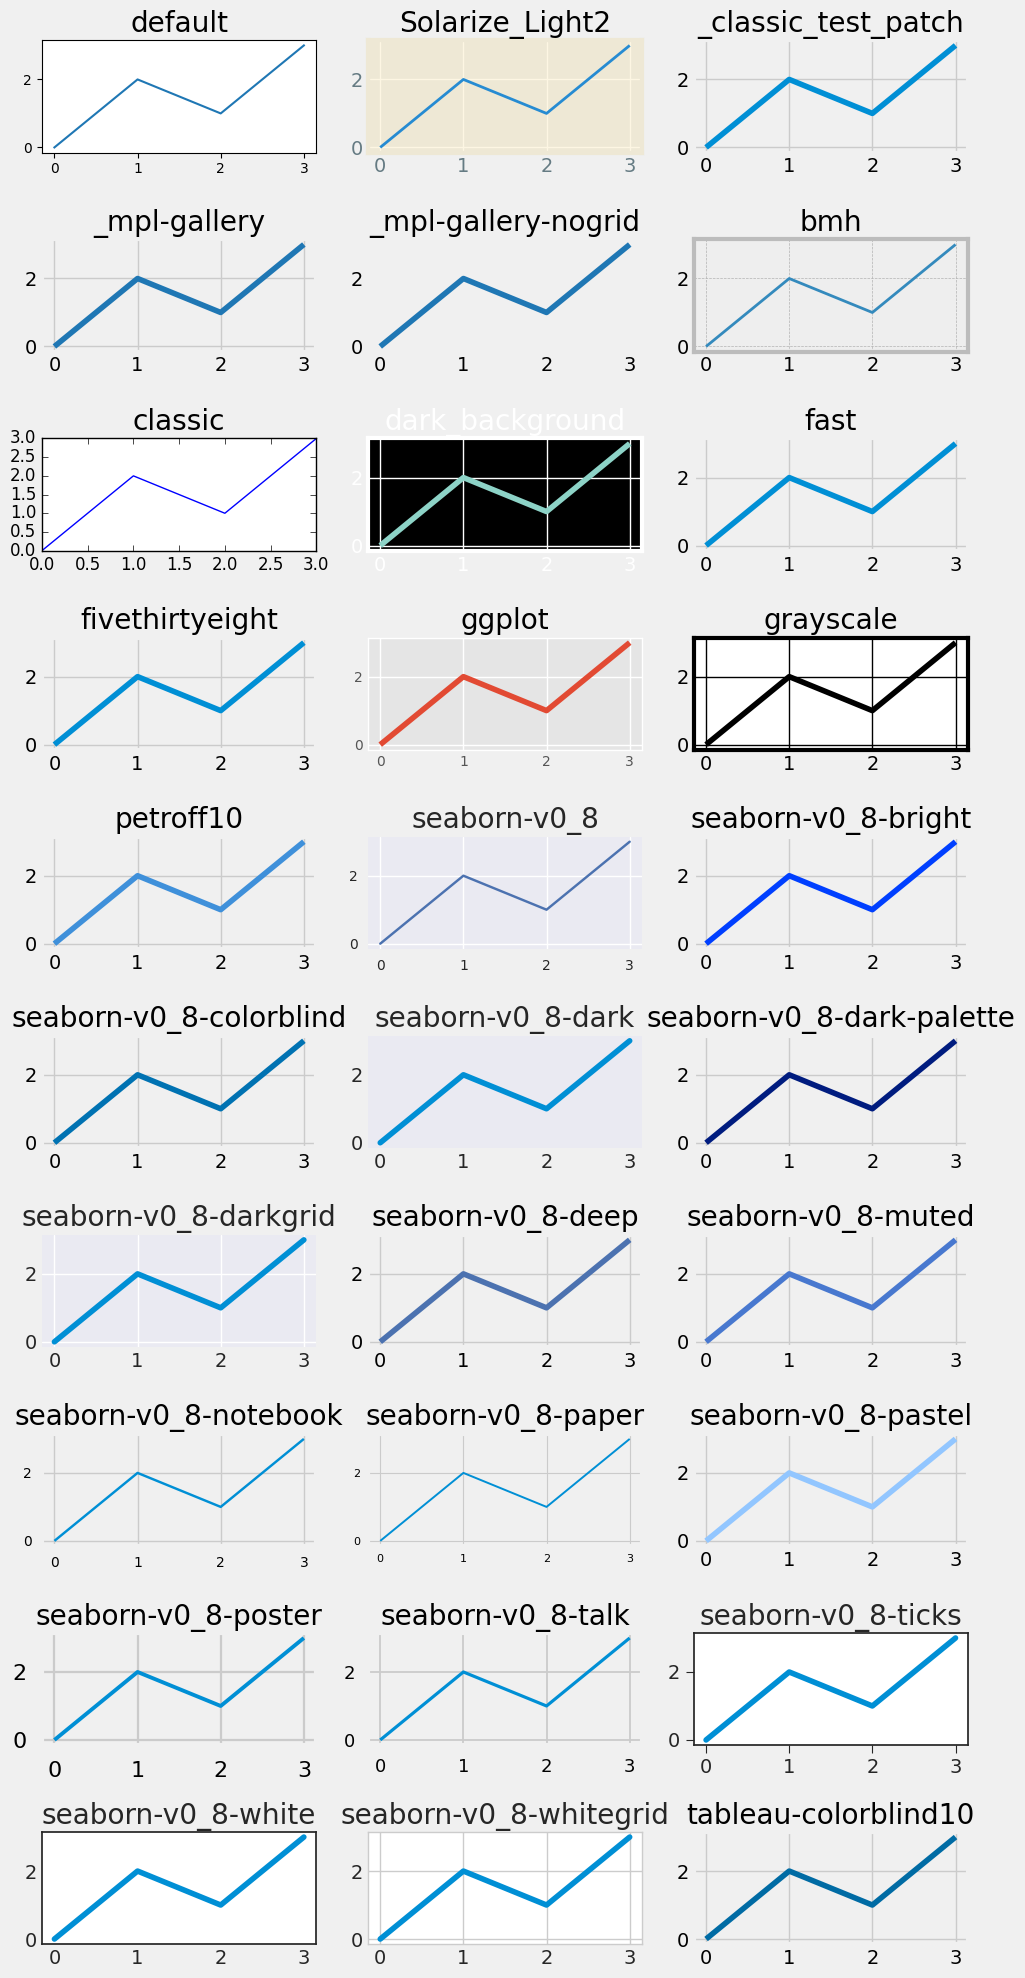

In [18]:
# plot all styles

fig = plt.figure(dpi=100, figsize=(10, 20), tight_layout=True)
available = ['default'] + plt.style.available
for i, style in enumerate(available):
    with plt.style.context(style):
        ax = fig.add_subplot(10, 3, i + 1)
        ax.plot([0, 1, 2, 3], [0, 2, 1, 3])
    ax.set_title(style)

# rcParams

In [20]:
# Return parameters for specific style
plt.style.library["seaborn-v0_8-darkgrid"]

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': 'white',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytic

In [ ]:
# return current set of parameters

# plt.rcParams.keys()

In [ ]:
plt.rc('lines', linewidth=3, linestyle='--')
plt.rc('legend', frameon=False, loc='lower right')

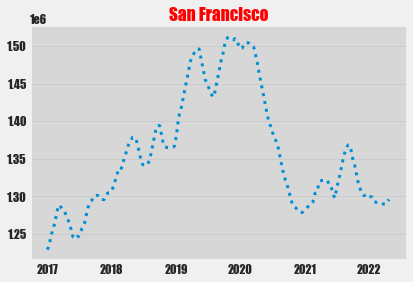

In [ ]:
# Various changes to rcParams

fig, ax = plt.subplots()

plt.rc("lines", linestyle=":", color="blue", linewidth="3")

font_settings = {
    "size": "12",
    'family':'fantasy',
    'fantasy': ["Impact"]
}

plt.rc('font', **font_settings)

text_settings = {
    "color": "r",
}

plt.rc('text', **text_settings)

axes_settings = {
    "spines.top": False,
    "spines.right": False,
    "facecolor": (0, 0, 0, .1),
    #"facealpha":.4,
    "grid": True, 
    "grid.axis": 'y'
    
}

plt.rc("axes", **axes_settings)

ax.plot(ca_housing_pivot.index, ca_housing_pivot["San Francisco"])
ax.set_title("San Francisco")

plt.show()

# Saving Figures

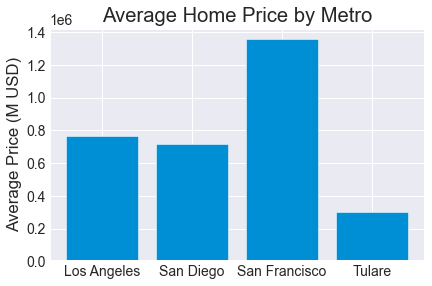

In [ ]:
sns.set_style("darkgrid")

fig, ax = plt.subplots()

ax.set_title("Average Home Price by Metro")
ax.set_ylabel("Average Price (M USD)")

ax.bar(means.index, means["Mean Price"])

plt.savefig("Home_Price.jpeg", dpi=1000)  # dpi modifies image resolution

In [ ]:
plt.gcf().canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format'}

<Figure size 432x288 with 0 Axes>